## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os

import random


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 190kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.53MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.5MB/s]


In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here

            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, input_shape),
            nn.ReLU(),
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
              ReLU-6                  [-1, 256]               0
           Dropout-7                  [-1, 256]               0
            Linear-8                  [-1, 784]         201,488
              ReLU-9                  [-1, 784]               0
Total params: 734,736
Trainable params: 734,736
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 2.80
Estimated Total Size (MB): 2.84
-------------------------------------------

Your experiments come here:

Epoch 15/15 | train: loss=0.2395, acc=0.9092 | test:  loss=0.3203, acc=0.8874


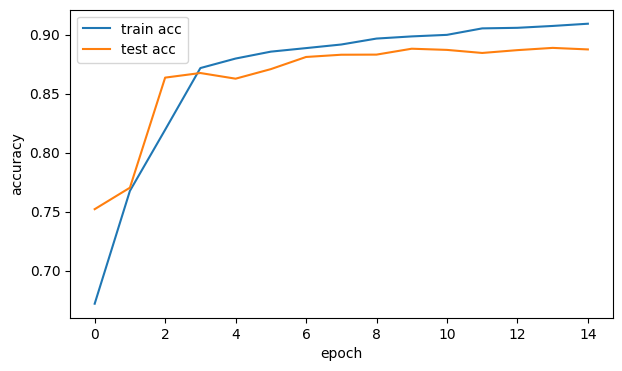

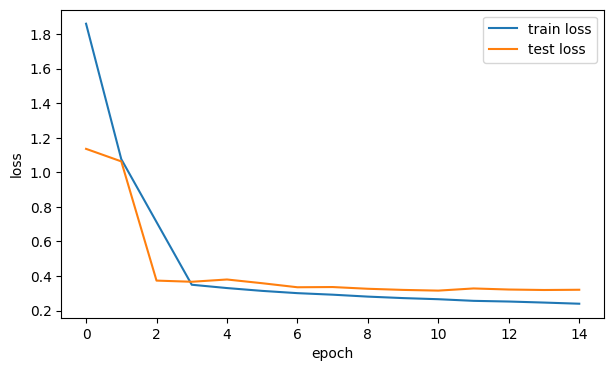

Best test accuracy: 0.8887


In [9]:

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

model = TinyNeuralNetwork().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here

def train_one_epoch(model, loader, opt, loss_func, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        opt.zero_grad(set_to_none=True)
        logits = model(x)
        loss = loss_func(logits, y)
        loss.backward()
        opt.step()

        total_loss += loss.item() * y.size(0)
        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    return total_loss / total, total_correct / total

@torch.no_grad()
def evaluate(model, loader, loss_func, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = loss_func(logits, y)

        total_loss += loss.item() * y.size(0)
        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    return total_loss / total, total_correct / total

def fit(model, train_loader, test_loader, opt, loss_func, epochs, device):
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    for epoch in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, opt, loss_func, device)
        te_loss, te_acc = evaluate(model, test_loader, loss_func, device)

        train_losses.append(tr_loss)
        train_accs.append(tr_acc)
        test_losses.append(te_loss)
        test_accs.append(te_acc)

        clear_output(wait=True)
        print(f"Epoch {epoch:02d}/{epochs} | "
              f"train: loss={tr_loss:.4f}, acc={tr_acc:.4f} | "
              f"test:  loss={te_loss:.4f}, acc={te_acc:.4f}")

        plt.figure(figsize=(7, 4))
        plt.plot(train_accs, label="train acc")
        plt.plot(test_accs, label="test acc")
        plt.xlabel("epoch")
        plt.ylabel("accuracy")
        plt.legend()
        plt.show()

        plt.figure(figsize=(7, 4))
        plt.plot(train_losses, label="train loss")
        plt.plot(test_losses, label="test loss")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend()
        plt.show()

    return train_losses, train_accs, test_losses, test_accs

train_losses, train_accs, test_losses, test_accs = fit(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    opt=opt,
    loss_func=loss_func,
    epochs=15,
    device=device
)

print("Best test accuracy:", max(test_accs))

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [16]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here

            nn.Linear(input_shape, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_shape),
            nn.ReLU(),

        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [17]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 2048]       1,607,680
              ReLU-3                 [-1, 2048]               0
            Linear-4                 [-1, 2048]       4,196,352
              ReLU-5                 [-1, 2048]               0
            Linear-6                 [-1, 1024]       2,098,176
              ReLU-7                 [-1, 1024]               0
            Linear-8                  [-1, 784]         803,600
              ReLU-9                  [-1, 784]               0
Total params: 8,705,808
Trainable params: 8,705,808
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 33.21
Estimated Total Size (MB): 33.31
-------------------------------------

Epoch 30/30 | train: loss=0.7762, acc=0.8760 | test:  loss=1.5639, acc=0.7283


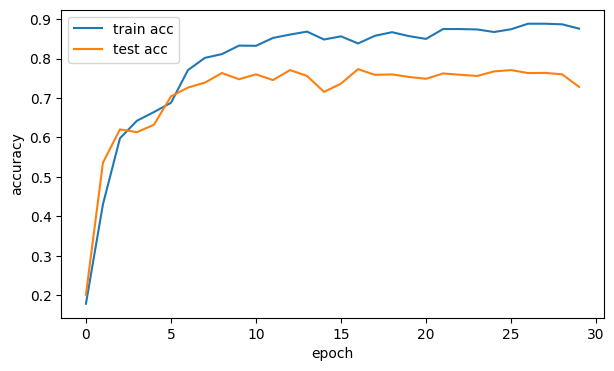

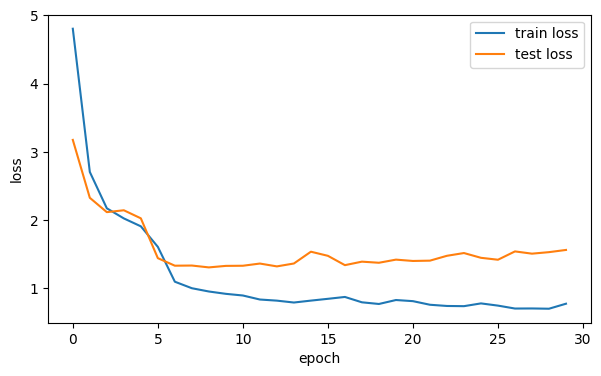

Best train accuracy: 0.8885
Best test accuracy: 0.7733


In [18]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=2e-3)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

subset_size = 2000
subset_indices = torch.randperm(len(fmnist_dataset_train))[:subset_size]
small_train_dataset = torch.utils.data.Subset(fmnist_dataset_train, subset_indices)

small_train_loader = torch.utils.data.DataLoader(
    small_train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2
)

train_losses, train_accs, test_losses, test_accs = fit(
    model=model,
    train_loader=small_train_loader,
    test_loader=test_loader,
    opt=opt,
    loss_func=loss_func,
    epochs=30,
    device=device
)

print("Best train accuracy:", max(train_accs))
print("Best test accuracy:", max(test_accs))

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [19]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            nn.Linear(1024, input_shape),
            nn.ReLU(),

        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [20]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 2048]       1,607,680
              ReLU-3                 [-1, 2048]               0
       BatchNorm1d-4                 [-1, 2048]           4,096
           Dropout-5                 [-1, 2048]               0
            Linear-6                 [-1, 1024]       2,098,176
              ReLU-7                 [-1, 1024]               0
       BatchNorm1d-8                 [-1, 1024]           2,048
           Dropout-9                 [-1, 1024]               0
           Linear-10                  [-1, 784]         803,600
             ReLU-11                  [-1, 784]               0
Total params: 4,515,600
Trainable params: 4,515,600
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

Epoch 20/20 | train: loss=0.9762, acc=0.8269 | test:  loss=0.8874, acc=0.8577


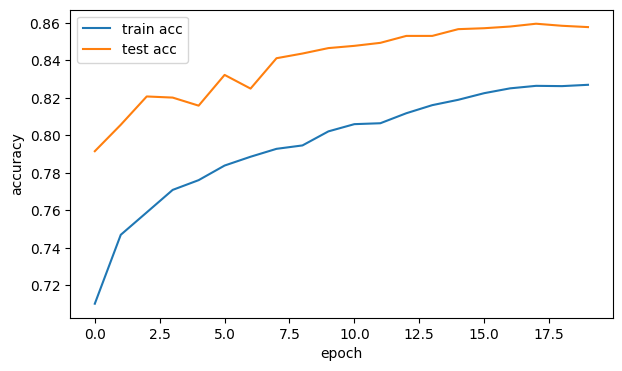

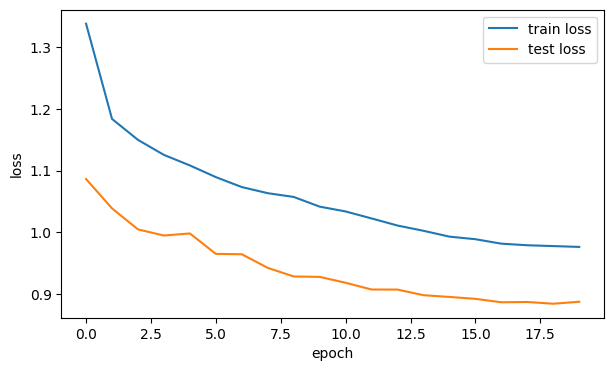

Best test accuracy: 0.8595


In [21]:
aug_train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.08, 0.08), scale=(0.9, 1.1)),
    transforms.ToTensor(),
])

fmnist_dataset_train_aug = torchvision.datasets.FashionMNIST(
    root_path,
    train=True,
    transform=aug_train_transform,
    target_transform=None,
    download=False
)

train_loader_aug = torch.utils.data.DataLoader(
    fmnist_dataset_train_aug,
    batch_size=128,
    shuffle=True,
    num_workers=2
)

model = FixedNeuralNetwork().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-4)
loss_func = nn.CrossEntropyLoss(label_smoothing=0.05)

# Your experiments, come here
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=20)

train_losses, train_accs, test_losses, test_accs = [], [], [], []

epochs = 20
for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader_aug, opt, loss_func, device)
    te_loss, te_acc = evaluate(model, test_loader, loss_func, device)

    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    test_losses.append(te_loss)
    test_accs.append(te_acc)

    scheduler.step()

    clear_output(wait=True)
    print(f"Epoch {epoch:02d}/{epochs} | "
          f"train: loss={tr_loss:.4f}, acc={tr_acc:.4f} | "
          f"test:  loss={te_loss:.4f}, acc={te_acc:.4f}")

    plt.figure(figsize=(7, 4))
    plt.plot(train_accs, label="train acc")
    plt.plot(test_accs, label="test acc")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(train_losses, label="train loss")
    plt.plot(test_losses, label="test loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

print("Best test accuracy:", max(test_accs))

### Conclusions:
_Write down small report with your conclusions and your ideas._


What we observed comparing train and test acc:
1) TinyNeuralNetwork: small train/test gap -> learns useful structure and generalizes well
2) OverfittingNeuralNetwork: classic overfitting signature: large train/test gap -> it fits the training subset much better than it generalizes
3) FixedNeuralNetwork: regularization reduced overfitting, improved stability/generalization compared to the overfitting model

Overall, the TinyNeuralNetwork model wins for this setup: it reaches the target and has the smallest train/test gap
We were able to combat the overfitting in the FixedNeuralNetwork but regularization is heavy enough that it also suppresses training accuracy
So, it doesnt beat the TinyNeuralNetwork model